In [1]:
%config InlineBackend.figure_format = "svg"

import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np

# Import data

In [2]:
# Path of the data
datapath = "data"

# Files to gather
files = glob(datapath + "/*.h5")

# Display all available files
print(files)

['data/wohg_hq1200.h5', 'data/hg3000_hq1000.h5', 'data/fcnc.h5', 'data/wohg_hq1400.h5', 'data/hg3000_hq1400.h5', 'data/hg3000_hq1200.h5', 'data/wohg_hq1000.h5', 'data/bkg.h5']


## Apply data-cuts

In [3]:
def cut_df(file: str, seed: int):
    """
    A function that applies cuts to an .h5 or .csv data file.
    Returns a pandas dataframe.
    
    Questions: 
        - Do I have to sort dataframe initially? How so?
        - Do I have to recalculate weights for future support and query splits?
    
    Data-cuts applied according to model transferability paper: https://arxiv.org/pdf/1912.04220.pdf
        - At least 2 final state leptons
        - At least 1 b-tagged jet
        - Must have a large scalar sum of transverse momentum (>500GeV)
    """
    
    # Assertions
    assert seed > 0, "Invalid seed."
    
    # Read dataframe and sort indices
    df = pd.read_hdf(file)
    df = df.sort_index()
    
    # Initial size
    initial_size = len(df)
    
    # Apply data cuts
    df = df[(df["Electron_Multi"] + df["Muon_Multi"]) > 1]
    df = df[(df["Jet1_BTag"] + df["Jet2_BTag"] + df["Jet3_BTag"] + df["Jet4_BTag"] + df["Jet5_BTag"]) > 0]
    df = df[df["ScalarHT_HT"] > 500]
    
    # Determine cut ratio
    split = df["gen_split"].iloc[0].capitalize()
    cut_ratio = 100 * (initial_size - len(df)) / initial_size
    
    # Display cut ratio information
    filename = file.split("/")[-1].split(".")[0]
    spacing = 0 if split == "Train" else (1 if split == "Test" else 2)
    print(f"File: {filename} | Split: {split}" + spacing*" " + f" | Drop ratio: {cut_ratio}%")
    
    return df

In [6]:
# Define data parameters
data_dict = {}
random_seed = 42

# Populate data dict
for file in tqdm(files, total=len(files), desc="Processing data"):
    # Insert data into dictionary
    filename = file.split("/")[-1].split(".")[0]
    data_dict[filename] = cut_df(file, random_seed)

Processing data:  12%|█▎        | 1/8 [00:00<00:05,  1.31it/s]

File: wohg_hq1200 | Split: Test  | Drop ratio: 3.169875545154771%


Processing data:  25%|██▌       | 2/8 [00:01<00:03,  1.64it/s]

File: hg3000_hq1000 | Split: Test  | Drop ratio: 2.443991853360489%


Processing data:  38%|███▊      | 3/8 [00:01<00:02,  1.73it/s]

File: fcnc | Split: Val   | Drop ratio: 0.0%


Processing data:  50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

File: wohg_hq1400 | Split: Train | Drop ratio: 2.757437070938215%


Processing data:  62%|██████▎   | 5/8 [00:02<00:01,  2.44it/s]

File: hg3000_hq1400 | Split: Test  | Drop ratio: 2.1137614678899084%


Processing data:  75%|███████▌  | 6/8 [00:02<00:00,  2.80it/s]

File: hg3000_hq1200 | Split: Val   | Drop ratio: 2.3649893170264495%


Processing data:  88%|████████▊ | 7/8 [00:02<00:00,  3.04it/s]

File: wohg_hq1000 | Split: Test  | Drop ratio: 3.4287204223974967%


Processing data: 100%|██████████| 8/8 [00:13<00:00,  1.72s/it]

File: bkg | Split: Train | Drop ratio: 0.33191496821583044%


## Plot the data

In [45]:
def plot_histograms(plot_dict, files: [(str, str)], scale="log", bins=50):
    """
    A functions that draws a histogram for a single feature.
    """
    
    # Assertions
    assert columns > 0, "Invalid number of columns."
    assert len(files) > 0, "Choose at least one file to plot"
    
    # Select the correct data splits
    data_dict = {}
    for file, split in files:
        df = plot_dict[file]
        if split != "all": df = df[df["gen_split"] == split]
        data_dict[f"{split} {file}"] = df
    files = [f"{file[1]} {file[0]}" for file in files]
        
    # Get features to plot
    drop_cols = [col for col in data_dict[files[0]].columns.to_list() if "gen" in col]
    features = data_dict[files[0]].drop(columns=drop_cols).columns.to_list()
    
    # Define rows and columns for subplot
    columns = 5
    rows = int(np.ceil(len(features)/columns))
    
    # Create axis
    fig, axs = plt.subplots(rows, columns, figsize=(40, 60))
    
    # Plot every feature
    for i, feature in enumerate(features):
        # Define histogram range
        hist_min = min([data_dict[file][feature].min() for file in files])
        hist_max = max([data_dict[file][feature].max() for file in files])
        hist_range = (hist_min, hist_max)

        # Adjust plot axis
        row, col = i // columns, i % columns
        axs[row, col].set_title(features[i])
        axs[row, col].set_yscale(scale)
        
        # Plot histogram for each file 
        for file in files:
            axs[row, col].hist(data_dict[file][feature], bins=bins, label=file, alpha=0.8, range=hist_range,
                               weights=data_dict[file]["gen_weights"], histtype='step')
        axs[row, col].legend()
    plt.show()

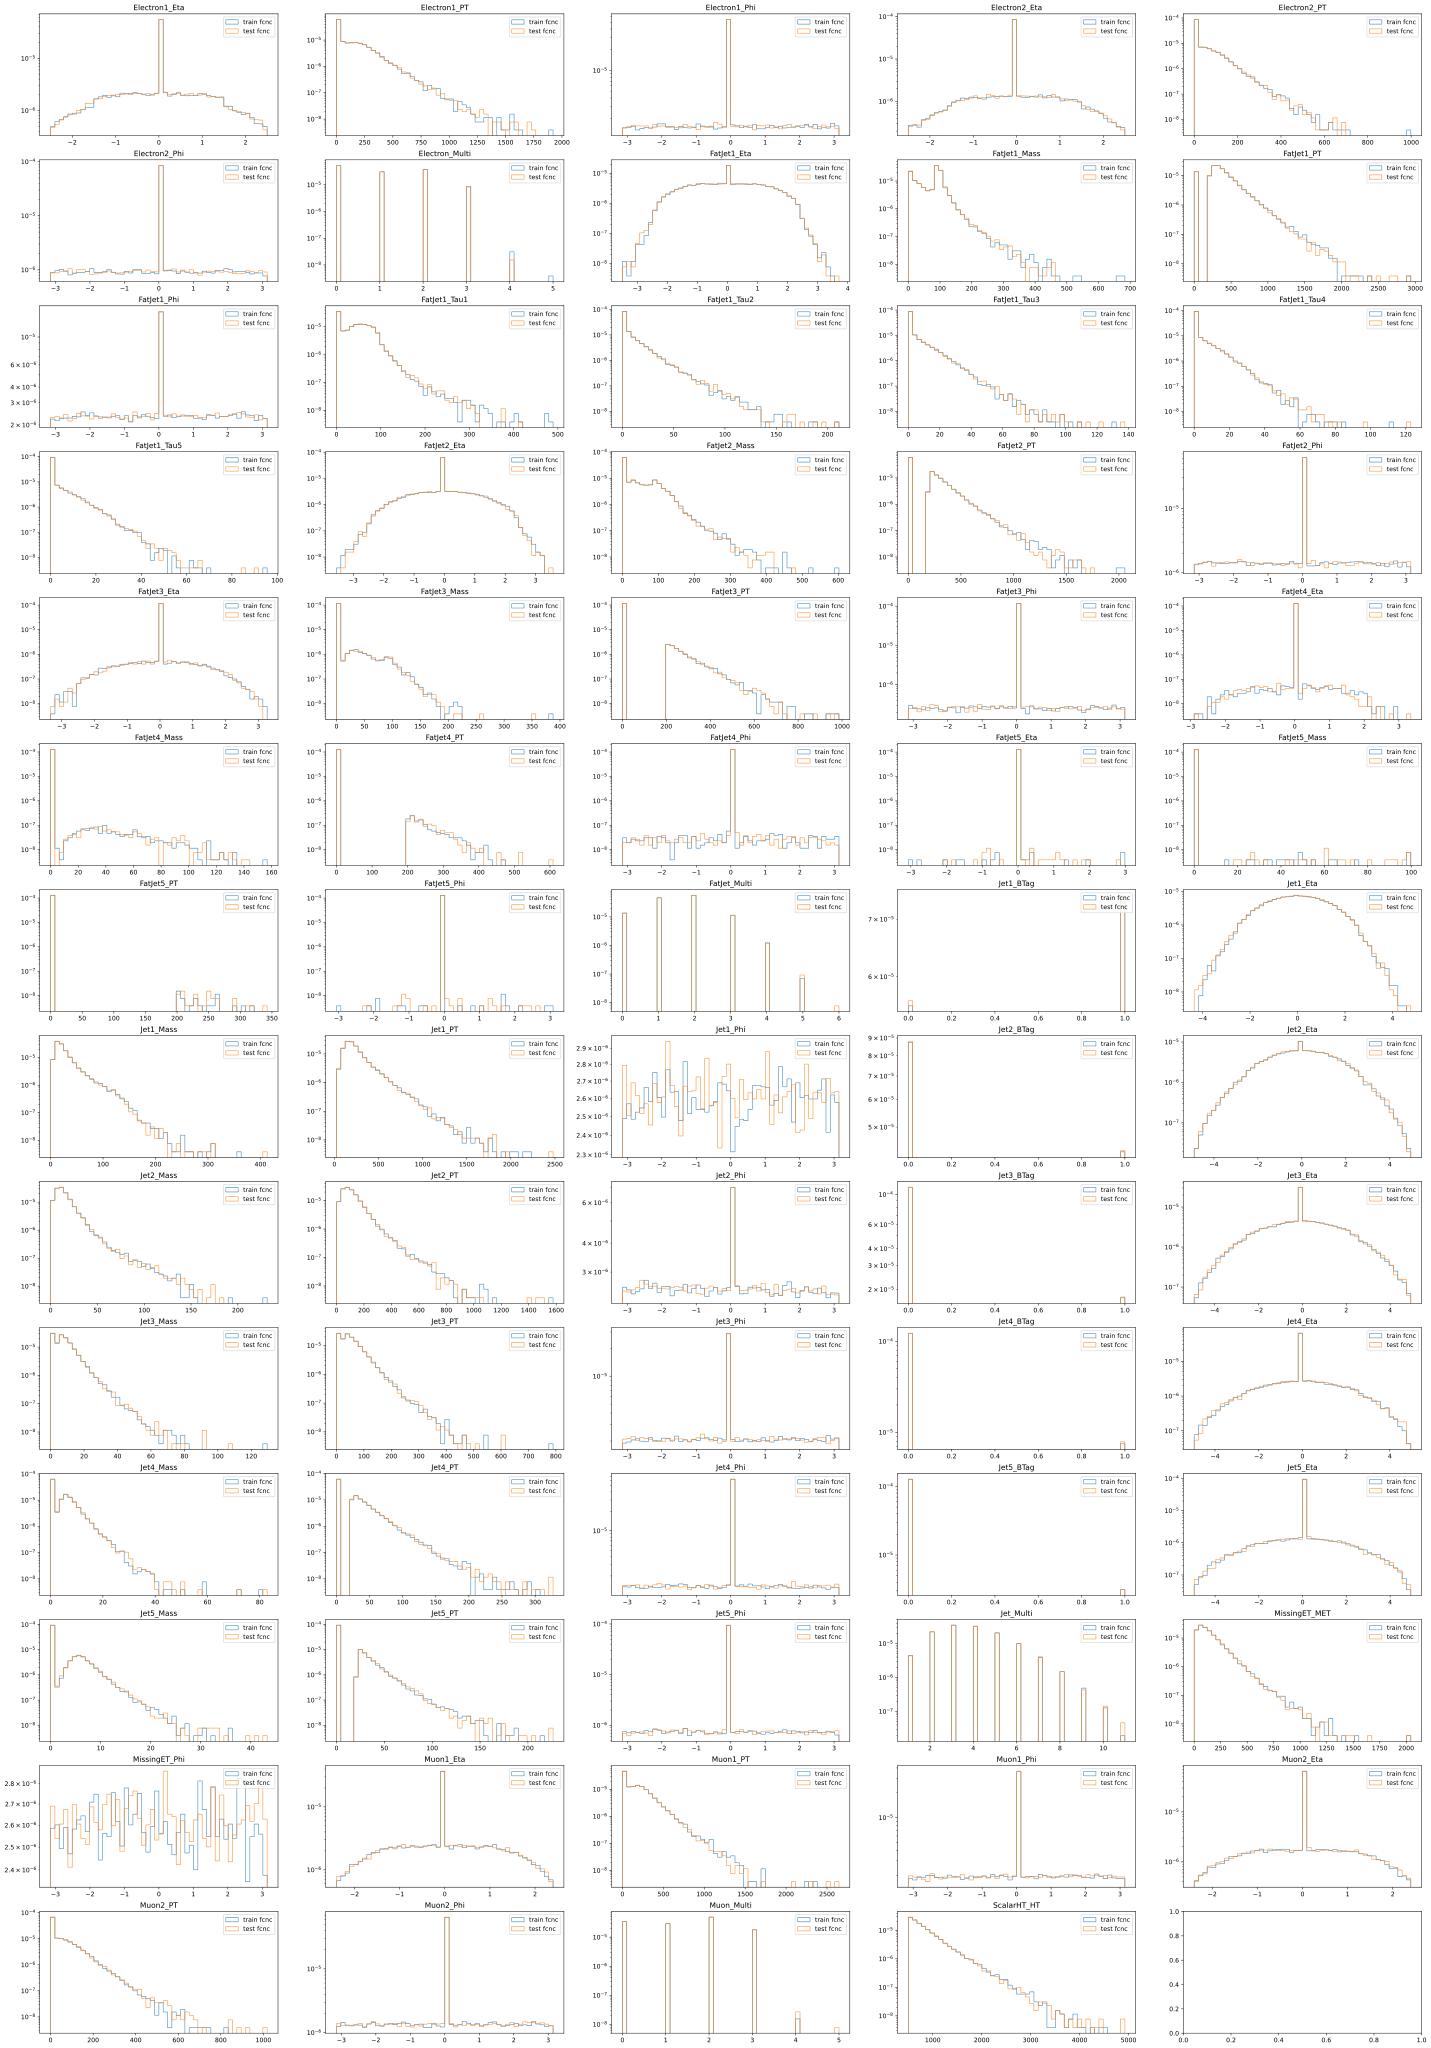

In [46]:
# Plot arguments
plot_files = [("fcnc", "train"), ("fcnc", "test")]
scale = "log"
bins = 50

# Plot the histograms
plot_histograms(data_dict, plot_files, scale, bins)

## Create a DataLoader class